In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [19]:
#%reload_ext cudf.pandas

In [20]:
pd.set_option('display.max_columns', 500)

train = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
train["Policy Start Date"] = pd.to_datetime( train["Policy Start Date"] )
train["year"] = train["Policy Start Date"].dt.year.astype("float32")
train["month"] = train["Policy Start Date"].dt.month.astype("float32")
train["day"] = train["Policy Start Date"].dt.day.astype("float32")
train["dow"] = train["Policy Start Date"].dt.dayofweek.astype("float32")
train["seconds"] = (train["Policy Start Date"].astype("int64") // 10**9).astype("float32")
train["y"] = np.log1p( train["Premium Amount"] )
print( train.shape )
train.head()

(1200000, 27)


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,year,month,day,dow,seconds,y
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0,2023.0,12.0,23.0,5.0,1.703345e+09,7.962067
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,<NA>,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0,2023.0,6.0,12.0,0.0,1.686583e+09,7.302496
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,<NA>,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0,2023.0,9.0,30.0,5.0,1.696087e+09,6.342121
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,<NA>,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0,2024.0,6.0,12.0,2.0,1.718206e+09,6.641182
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0,2021.0,12.0,1.0,2.0,1.638372e+09,7.612337


In [21]:
test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
test["Policy Start Date"] = pd.to_datetime( test["Policy Start Date"] )
test["year"] = test["Policy Start Date"].dt.year.astype("float32")
test["month"] = test["Policy Start Date"].dt.month.astype("float32")
test["day"] = test["Policy Start Date"].dt.day.astype("float32")
test["dow"] = test["Policy Start Date"].dt.dayofweek.astype("float32")
test["seconds"] = (test["Policy Start Date"].astype("int64") // 10**9).astype("float32")
print( test.shape )
test.head()

(800000, 25)


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,year,month,day,dow,seconds
0,1200000,28.0,Female,2310.0,<NA>,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,<NA>,19.0,<NA>,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House,2023.0,6.0,4.0,6.0,1.685892e+09
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,<NA>,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment,2024.0,4.0,22.0,0.0,1.713799e+09
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,<NA>,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo,2023.0,4.0,5.0,2.0,1.680708e+09
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House,2023.0,10.0,25.0,2.0,1.698247e+09
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,<NA>,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House,2021.0,11.0,26.0,4.0,1.637940e+09


In [22]:
RMV = ["id","Policy Start Date","Premium Amount","y"]
FEATURES = [c for c in train.columns if not c in RMV]
combined = pd.concat([train,test],axis=0,ignore_index=True)

CATS = []
HIGH_CARDINALITY = []
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")

for c in FEATURES:
    ftype = "numerical"
    if combined[c].dtype=="object":
        CATS.append(c)
        combined[c] = combined[c].fillna("NAN")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        ftype = "categorical"
    if combined[c].dtype=="int64":
        combined[c] = combined[c].astype("int32")
    elif combined[c].dtype=="float64":
        combined[c] = combined[c].astype("float32")
        
    n = combined[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=9: HIGH_CARDINALITY.append(c)
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

print("\nTHE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES:", HIGH_CARDINALITY )

THE 23 BASIC FEATURES ARE:
Age (numerical) with 47 unique values
Gender (categorical) with 2 unique values
Annual Income (numerical) with 97540 unique values
Marital Status (categorical) with 4 unique values
Number of Dependents (numerical) with 5 unique values
Education Level (categorical) with 4 unique values
Occupation (categorical) with 4 unique values
Health Score (numerical) with 640260 unique values
Location (categorical) with 3 unique values
Policy Type (categorical) with 3 unique values
Previous Claims (numerical) with 10 unique values
Vehicle Age (numerical) with 20 unique values
Credit Score (numerical) with 550 unique values
Insurance Duration (numerical) with 9 unique values
Customer Feedback (categorical) with 4 unique values
Smoking Status (categorical) with 2 unique values
Exercise Frequency (categorical) with 4 unique values
Property Type (categorical) with 3 unique values
year (numerical) with 6 unique values
month (numerical) with 12 unique values
day (numerical) wit

In [23]:
lists2 = [['Annual Income', 'Health Score'], ['Credit Score', 'Health Score'], ['Customer Feedback', 'Gender', 'Marital Status', 'Occupation', 'Smoking Status', 'year'], ['Exercise Frequency', 'Health Score'], ['Health Score', 'Marital Status'], ['Education Level', 'Gender', 'Health Score'], ['Health Score', 'Occupation'], ['Age', 'Health Score'], ['Health Score', 'dow'], ['Age', 'Exercise Frequency', 'Location'], ['Health Score', 'Smoking Status', 'month'], ['Health Score', 'Location', 'Policy Type'], ['Health Score', 'Insurance Duration'], ['Health Score', 'Number of Dependents'], ['Customer Feedback', 'Exercise Frequency', 'Previous Claims', 'Property Type', 'dow'], ['Customer Feedback', 'Health Score'], ['Health Score', 'Property Type'], ['Health Score', 'day', 'seconds'], ['Health Score', 'year'], ['Age', 'Gender', 'Insurance Duration', 'year']]
print(f"We have {len(lists2)} powerful combination of columns!")

We have 20 powerful combination of columns!


In [24]:
def target_encode(train, valid, test, col, target="y", kfold=5, smooth=20, agg="mean"):

    train['kfold'] = ((train.index) % kfold)
    col_name = '_'.join(col)
    train[f'TE_{agg.upper()}_' + col_name] = 0.
    for i in range(kfold):
        
        df_tmp = train[train['kfold']!=i]
        if agg=="mean": mn = train[target].mean()
        elif agg=="median": mn = train[target].median()
        elif agg=="min": mn = train[target].min()
        elif agg=="max": mn = train[target].max()
        elif agg=="nunique": mn = 0
        df_tmp = df_tmp[col + [target]].groupby(col).agg([agg, 'count']).reset_index()
        df_tmp.columns = col + [agg, 'count']
        if agg=="nunique":
            df_tmp['TE_tmp'] = df_tmp[agg] / df_tmp['count']
        else:
            df_tmp['TE_tmp'] = ((df_tmp[agg]*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        df_tmp_m = train[col + ['kfold', f'TE_{agg.upper()}_' + col_name]].merge(df_tmp, how='left', left_on=col, right_on=col)
        df_tmp_m.loc[df_tmp_m['kfold']==i, f'TE_{agg.upper()}_' + col_name] = df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_tmp']
        train[f'TE_{agg.upper()}_' + col_name] = df_tmp_m[f'TE_{agg.upper()}_' + col_name].fillna(mn).values  
    
    df_tmp = train[col + [target]].groupby(col).agg([agg, 'count']).reset_index()
    if agg=="mean": mn = train[target].mean()
    elif agg=="median": mn = train[target].median()
    elif agg=="min": mn = train[target].min()
    elif agg=="max": mn = train[target].max()
    elif agg=="nunique": mn = 0
    df_tmp.columns = col + [agg, 'count']
    if agg=="nunique":
        df_tmp['TE_tmp'] = df_tmp[agg] / df_tmp['count']
    else:
        df_tmp['TE_tmp'] = ((df_tmp[agg]*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
    df_tmp_m = valid[col].merge(df_tmp, how='left', left_on=col, right_on=col)
    valid[f'TE_{agg.upper()}_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    valid[f'TE_{agg.upper()}_' + col_name] = valid[f'TE_{agg.upper()}_' + col_name].astype("float32")

    df_tmp_m = test[col].merge(df_tmp, how='left', left_on=col, right_on=col)
    test[f'TE_{agg.upper()}_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    test[f'TE_{agg.upper()}_' + col_name] = test[f'TE_{agg.upper()}_' + col_name].astype("float32")

    train = train.drop('kfold', axis=1)
    train[f'TE_{agg.upper()}_' + col_name] = train[f'TE_{agg.upper()}_' + col_name].astype("float32")

    return(train, valid, test)

In [25]:
from xgboost import XGBRegressor
import xgboost as xgb, time
print(f"Using XGBoost version",xgb.__version__)

Using XGBoost version 2.0.3


In [26]:
%%time

FOLDS = 20
from sklearn.model_selection import KFold
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros(len(train))
pred = np.zeros(len(test))


for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES+["y"] ].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    start = time.time()
    print(f"FEATURE ENGINEER {len(FEATURES)} COLUMNS and {len(lists2)} GROUPS: ",end="")
    for j,f in enumerate(FEATURES+lists2):

        if j<len(FEATURES): c = [f]
        else: c = f 
        print(f"({j+1}){c}",", ",end="")

        # LOW CARDINALITY FEATURES - TARGET ENCODE MEAN AND MEDIAN
        x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=20, agg="mean")
        x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="median")

        # HIGH CARDINALITY FEATURES - TE MIN, MAX, NUNIQUE and CE
        if (j>=len(FEATURES)) | (c[0] in HIGH_CARDINALITY):
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="min")
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="max")
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="nunique")
    
            # COUNT ENCODING (USING COMBINED TRAIN TEST)
            tmp = combined.groupby(c).y.count()
            nm = f"CE_{'_'.join(c)}"; tmp.name = nm
            x_train = x_train.merge(tmp, on=c, how="left")
            x_valid = x_valid.merge(tmp, on=c, how="left")
            x_test = x_test.merge(tmp, on=c, how="left")
            x_train[nm] = x_train[nm].astype("int32")
            x_valid[nm] = x_valid[nm].astype("int32")
            x_test[nm] = x_test[nm].astype("int32")
            
    end = time.time()
    elapsed = end-start
    print(f"Feature engineering took {elapsed:.1f} seconds")
    x_train = x_train.drop("y",axis=1)

    model = XGBRegressor(
        device="cuda",
        max_depth=8, 
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=2_000, 
        learning_rate=0.01, 
        early_stopping_rounds=25,  
        eval_metric="rmse",
    )
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],   
        verbose=100
    )

    # INFER OOF
    oof[test_index] = model.predict(x_valid)
    # INFER TEST
    pred += model.predict(x_test)

    m = np.sqrt(np.mean( (y_valid.to_numpy() - oof[test_index])**2.0 )) 
    print(f" => Fold {i+1} RMSLE = {m:.5f}")

# COMPUTE AVERAGE TEST PREDS
pred /= FOLDS

#########################
### Fold 1
#########################
FEATURE ENGINEER 23 COLUMNS and 20 GROUPS: (1)['Age'] , (2)['Gender'] , (3)['Annual Income'] , (4)['Marital Status'] , (5)['Number of Dependents'] , (6)['Education Level'] , (7)['Occupation'] , (8)['Health Score'] , (9)['Location'] , (10)['Policy Type'] , (11)['Previous Claims'] , (12)['Vehicle Age'] , (13)['Credit Score'] , (14)['Insurance Duration'] , (15)['Customer Feedback'] , (16)['Smoking Status'] , (17)['Exercise Frequency'] , (18)['Property Type'] , (19)['year'] , (20)['month'] , (21)['day'] , (22)['dow'] , (23)['seconds'] , (24)['Annual Income', 'Health Score'] , (25)['Credit Score', 'Health Score'] , (26)['Customer Feedback', 'Gender', 'Marital Status', 'Occupation', 'Smoking Status', 'year'] , (27)['Exercise Frequency', 'Health Score'] , (28)['Health Score', 'Marital Status'] , (29)['Education Level', 'Gender', 'Health Score'] , (30)['Health Score', 'Occupation'] , (31)['Age', 'Health Score'] , (32)['Health Score

In [27]:
m = np.sqrt(np.mean( (train.y.values - oof)**2.0 )) 
print(f"Overall CV RMSLE = {m:.5f}")

Overall CV RMSLE = 1.01915


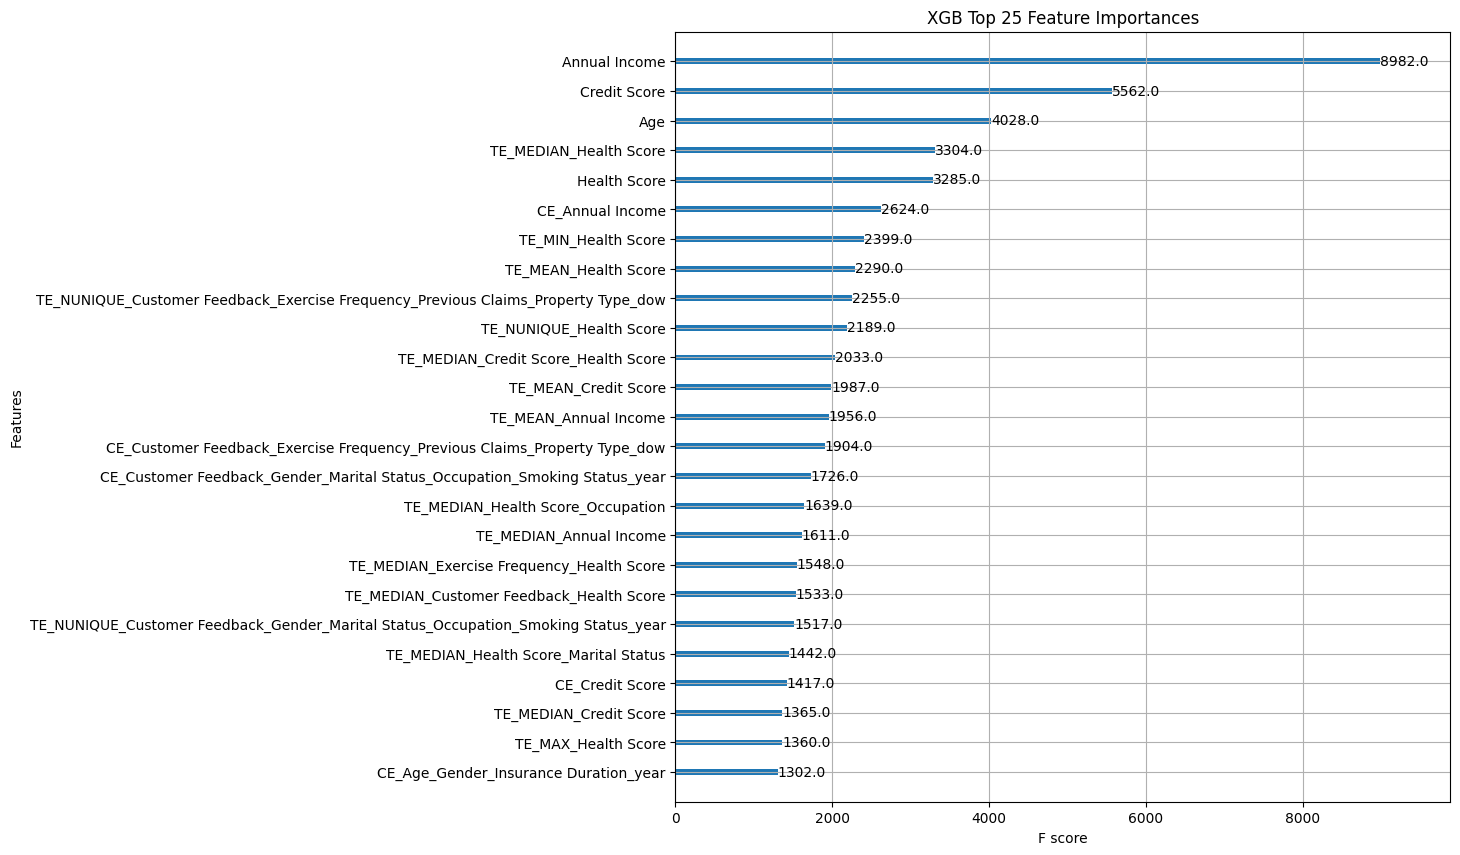

In [28]:
# Plot top 25 features by importance
#import matplotlib.pyplot as plt
#fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size if needed
#xgb.plot_importance(
 ##   model,
   # ax=ax,
#    max_num_features=25,  # Display only the top 25 features
#    importance_type="weight",  # Options: 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
#)
#plt.title("XGB Top 25 Feature Importances")
#plt.show()

In [29]:
sub = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")
sub["Premium Amount"] = np.exp( pred )-1
sub.to_csv("submission.csv",index=False)
print( sub.shape )
sub.head()

(800000, 2)


,id,Premium Amount
0,1200000,883.361574
1,1200001,928.924848
2,1200002,837.068903
3,1200003,782.201919
4,1200004,802.409668
